In [1]:
import numpy as np
from datetime import datetime
import os
import json
from pyeosim import spectral, atmosphere
from pyeosim import sensor
from pyeosim import datasets
import pysolar
import pandas as pd
import yaml
import colorcet as cc
import xarray
import matplotlib.pyplot as plt
from scipy.stats import linregress
import Py6S
import seaborn

def read_atmos_meta(path):
    """
    Loads JSON file containing atmospheric simulation parameters used in 6SV
    """
    jsons = os.listdir(path)
    jsons = [x for x in os.listdir(path) if x.endswith('json')]
    metas = {}
    for _json in jsons:
        with open(os.path.join(path, _json), 'r') as f:
            metas[_json.split('.')[0]] = json.load(f)
    return pd.DataFrame(metas).T

# applying spatial/spectral downsampling without sensor
def apply_downsampling(arr, sensor, spatial=True, spectral=False):
    if spectral:
        arr = sensor.spectral_response.transform(arr)
    if spatial:
        arr = sensor.steps[1][1](arr,
                                 sensor.psf_fwhm,
                                 sensor.ground_sample_distance)
    return arr
    
def sensor_correction_experiment(toa_radiance, sensor, mask=None):
    """
    Performs a calibration experiment based on an input radiance dataset
    and a sensor to give the correction factors needed to convert DN
    to apparent radiance. Note that this assumes a linear relationship
    between DN and radiance.
    
    Parameters
    ----------
    toa_radiance : xarray.DataArray
        At-sensor (top-of-atmosphere) Radiance
    sensor : pyeosim.sensor.Sensor
        A valid sensor instance
    
    Returns
    -------
    calibration_coefs : xarray.Dataset
        contains the m and c parameters for linear
        model to convert DN to radiance
    """
    # applying linear regression model
    def find_coeffs(radiance, sensor_output):
        # create vectors
        y = radiance.values.ravel()
        y = y[~np.isnan(y)]
        x = sensor_output.values.ravel()
        x = x[~np.isnan(x)]
        res = linregress(x, y)
        return res.slope, res.intercept

    # converting linregress coefs to xarray
    def corrections_to_xarray(corrs):
        df = pd.DataFrame(corrs).T
        m = xarray.DataArray(df[0], dims='band', name='m')
        c = xarray.DataArray(df[1], dims='band', name='c')
        return xarray.Dataset({'m':m,'c':c})
    
    # Sensor equivalent radiance
    dn = sensor.fit_transform(toa_radiance)
    L_s = apply_downsampling(toa_radiance,
                            sensor,
                            spatial=True, spectral=False)
    
    # iterate bands and apply linear regression to each band
    out = {}
    for i, b in enumerate(dn.band_name.values):
        if mask is not None:
            out[i] = find_coeffs(L_s.isel(band=i).where(mask),
                                    dn.isel(band=i).where(mask))
        else:
            out[i] = find_coeffs(L_s.isel(band=i),
                                    dn.isel(band=i))

    return corrections_to_xarray(out)

def convert_to_radiance(sensor_dn, corrections):
    """
    Converts DN to apparent radiance using corrections
    in a linear model y=mx + c
    
    Parameters
    ----------
    sensor_dn : xarray.DataArray
        sensor output in DN
    corrections : xarray.Dataset
        dataset with m and c variables
    
    Returns
    -------
    sensor_radiance : xarray.DataArray
        sensor output in radiance
    """
    return (sensor_dn * corrections['m'] ) + corrections['c']

def generate_mk_test_sixs(scenario):
    a = Py6S.SixS()
    a.ground_reflectance = Py6S.GroundReflectance.HomogeneousLambertian(1)
    a.altitudes.set_sensor_satellite_level()
    geom = Py6S.Geometry.User()
    geom.solar_z=scenario['solar_z']
    geom.solar_a=scenario['solar_a']
    geom.view_z=scenario['view_z']
    geom.view_a=scenario['view_a']
    geom.day=scenario['day']
    geom.month=scenario['month']
    a.geometry = geom
    ac = Py6S.AtmosCorr()
    a.atmos_corr = ac.AtmosCorrLambertianFromReflectance(.5)
    return a

# Generate Treeview 3 bandwidths
bw = xarray.DataArray(
    [20, 50, 50, 40, 40, 14, 14, 30],
    coords={'band': np.arange(8)}
)

# This data is bottom of atmosphere reflectance (approximated) and so is used as starting point for simulation
surface_reflectance = xarray.open_dataset(datasets.DATA_PATHS['TEST_HSI_LARGE']).Reflectance
surface_reflectance = surface_reflectance.swap_dims({'band':'wavelength'})
# slice between 400 and 898 to reduce data volume and align with the bandpass responses used later in simulation
# Also rescale to reflectance by divide by 10000
surface_reflectance = surface_reflectance.sel(wavelength=slice(400,898)).astype(float)/10000
# replace anything with a greater than 1 reflectance by truncating at 1
surface_reflectance = surface_reflectance.where(surface_reflectance <= 1, other=1)
# Load sensor configurations
sensor_configs = yaml.load(open('sensors.yaml', 'r'), Loader=yaml.Loader)
atmos_meta = read_atmos_meta('atmospheres/atmospheres_2/')

print('Available Sensor Configurations:')
print(list(sensor_configs.keys()))

print('Available Atmosphere Configurations:')
print(list(atmos_meta.index))

Available Sensor Configurations:
['TreeView_1_MSI_16', 'TreeView_1_MSI_32', 'TreeView_2_MSI_16', 'TreeView_2_MSI_32', 'TreeView_1_PAN_32', 'TreeView_1_PAN_64', 'TreeView_2_PAN_32', 'TreeView_2_PAN_64', 'TreeView_3_MSI_16', 'TreeView_3_MSI_32', 'TreeView_3_PAN_32', 'TreeView_3_PAN_64']
Available Atmosphere Configurations:
['inv_20200622_1030_nadir', 'inv_20200622_1200_nadir', 'inv_20200301_1030_nadir', 'inv_20201001_1030_nadir', 'inv_20200801_1030_nadir', 'inv_20200501_1030_nadir', 'mk_20200622_1030_nadir', 'mk_20200622_1200_nadir', 'mk_20200301_1030_nadir', 'mk_20201001_1030_nadir', 'mk_20200801_1030_nadir', 'mk_20200501_1030_nadir']


In [2]:
# atm_scenario = 'mk_20200622_1030_nadir'
atm_scenario = 'mk_20200801_1030_nadir'
atmos_meta.loc[atm_scenario]

version                                   1.1
month                                       8
day                                         1
solar_z                                    38
solar_a                                   143
view_z                                      0
view_a                                      0
scattering_angle                        141.2
azimuthal_angle_difference             143.05
visibility                               8.49
aot550                                    0.5
ground_pressure                        1013.0
ground_altitude                           0.0
apparent_reflectance                 1.003852
apparent_radiance                     458.572
total_gaseous_transmittance             0.979
wv_above_aerosol                        1.004
wv_mixed_with_aerosol                   1.004
wv_under_aerosol                        1.004
percent_direct_solar_irradiance         0.406
percent_diffuse_solar_irradiance        0.396
percent_environmental_irradiance  

In [3]:
teledyne_msi32 = sensor.TdiCmos(**sensor_configs['TreeView_3_MSI_32'], store_steps=True)
# teledyne_msi16 = sensor.TdiCmos(**sensor_configs['TreeView_3_MSI_16'])
atm = atmosphere.SixSV_atmosphere(generate_mk_test_sixs(atmos_meta.loc[atm_scenario]))
atm.fit(teledyne_msi32.spectral_response)

In [4]:
toa_radiance = atm.transform(surface_reflectance)
toa_radiance[:, 0:50, 312:362] = 0
# Generate equivalent reflectance (non-normalised) and radiance downsampled to sensor spatial/spectral
sensor_equiv_reflectance = apply_downsampling(surface_reflectance,
                                              teledyne_msi32,
                                              spatial=True, spectral=True)
sensor_equiv_radiance = apply_downsampling(toa_radiance,
                                           teledyne_msi32,
                                           spatial=True, spectral=False)
dark_region_mask = xarray.zeros_like(sensor_equiv_reflectance.isel(band=0)).astype(bool)
dark_region_mask[50:60, 50:60] = 1

corrections = sensor_correction_experiment(toa_radiance, teledyne_msi32, mask = ~dark_region_mask)
corrections

<xarray.Dataset>
Dimensions:  (band: 8)
Coordinates:
  * band     (band) int64 0 1 2 3 4 5 6 7
Data variables:
    m        (band) float64 0.001903 0.00152 0.001351 ... 0.001213 0.001673
    c        (band) float64 0.008185 0.0008643 ... -0.000203 -0.0002174

In [5]:
# Run a simulation
sensor_output = teledyne_msi32.transform(toa_radiance)

In [6]:
# Run a simulation
# Convert to radiance using Radiance = (m * DN) + c 
sensor_output_radiance = convert_to_radiance(sensor_output, corrections)


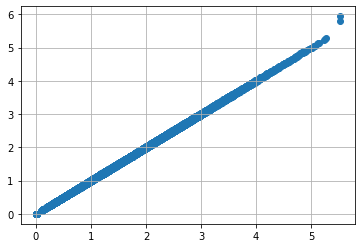

In [7]:
plt.scatter(
    sensor_output_radiance.to_numpy().ravel(),
    sensor_equiv_radiance.to_numpy().ravel())
plt.grid()

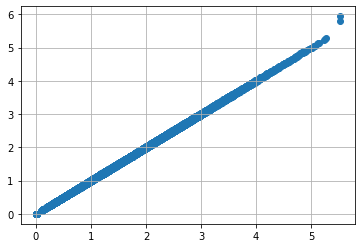

In [8]:
plt.scatter(
    sensor_output_radiance.to_numpy().ravel(),
    sensor_equiv_radiance.to_numpy().ravel())
plt.grid()

In [9]:
# def elliptical_orbit_correction(doy):
#     C0 = .03275104
#     C1 = 59.66638337
#     C2 = .96804905
#     return C0 * np.cos(doy/C1) + C2

# dark region is defined spatially


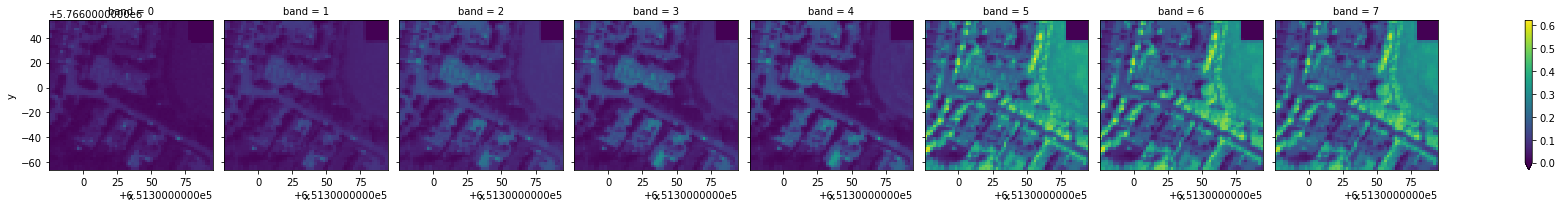

In [10]:
corrected = atm.inverse_transform(sensor_output_radiance)
corrected.plot(col='band',vmin=0)

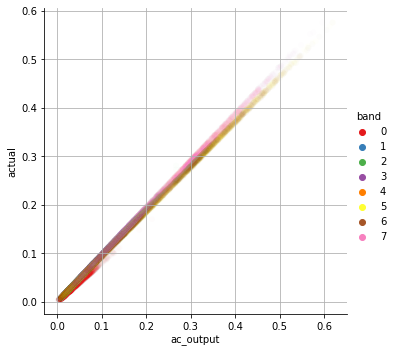

In [11]:
obs = (corrected).where(~dark_region_mask)
obs_df = obs.stack({'pix': ['y', 'x']}).to_dataframe(name='ac_output')

exp = (sensor_equiv_reflectance / bw).where(~dark_region_mask)
exp_df = exp.stack({'pix': ['y', 'x']}).to_dataframe(name='expected')

obs_df['actual'] = exp_df['expected']
seaborn.relplot(data=obs_df,
                x='ac_output',
                y='actual',
                hue='band',
                palette='Set1',
                alpha=.01)
plt.grid()

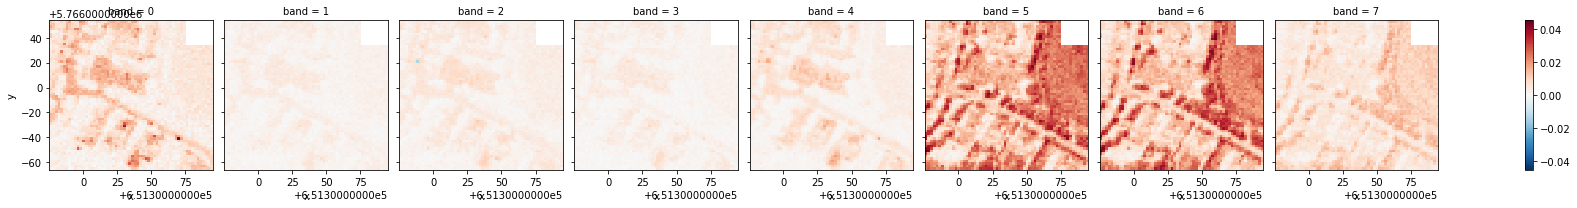

In [12]:
(obs - exp).plot(col='band')

Text(0.5, 0, 'Band')

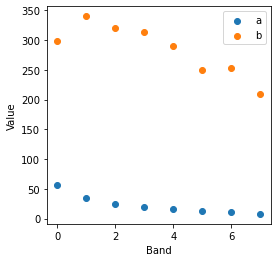

In [13]:
f,a = plt.subplots(ncols=1, figsize=(4,4))
atm._coefs.plot.scatter(x='band', y='a',ax=a, label='a')
atm._coefs.plot.scatter(x='band', y='b',ax=a, label='b')

a.legend()
a.set_ylabel('Value')
a.set_xlabel('Band')